In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import metrics
import matplotlib.pyplot as plt
import h5py
import os
pd.options.mode.chained_assignment = None

In [4]:
# all h5 files
h5_files = os.listdir('.')
h5_files = [name for name in h5_files if name.split('.')[1]=='h5']

# read all data
date_list = []
datetime_list = []
close_list = []
volume_list = []
turnover_list = []
TradesCount_list = []
for file_name in h5_files:
    with h5py.File(path+file_name, 'r+') as f:
        date_list = date_list + list(f['TradingDay'][()])
        datetime_list = datetime_list + list(f['DataTime'][()])
        close_list = close_list + list(f['LastPrice'][()])
        volume_list = volume_list + list(f['Volume'][()])
        turnover_list = turnover_list + list(f['Turnover'][()])
        TradesCount_list = TradesCount_list + list(f['TradesCount'][()])

# merge all time-series data   
data = pd.DataFrame(np.column_stack([date_list, datetime_list, close_list, volume_list, turnover_list, TradesCount_list]), columns=['TradingDay', 'DataTime', 'Close', 'Volume', 'Turnover', 'TradesCount'])
# convert to datetime format
data['TradingDay'] = [str(int(x)) for x in data['TradingDay']]
data['TradingDay'] = pd.to_datetime(data['TradingDay'], format='%Y%m%d')
data['DataTime'] = [str(int(x))[:-3] for x in data['DataTime']]
data['DataTime'] = pd.to_datetime(data['DataTime'], format='%Y%m%d%H%M%S')
# convert to daily data
daily_data = data.groupby('TradingDay').apply(lambda x: x.iloc[-1])[['Close', 'Volume', 'Turnover', 'TradesCount']]

In [5]:
daily_data

,Close,Volume,Turnover,TradesCount
TradingDay,,,,
2021-01-04,1997.00,4351400.0,8.686920e+09,29403.0
2021-01-05,2059.45,5211605.0,1.059256e+10,28864.0
2021-01-06,2100.00,4741020.0,9.882594e+09,29058.0
2021-01-07,2140.00,3793139.0,7.991179e+09,24997.0
2021-01-08,2090.00,5386164.0,1.134520e+10,36488.0
...,...,...,...,...
2021-12-27,2131.82,3755590.0,8.020678e+09,25893.0
2021-12-28,2138.18,2765070.0,5.901941e+09,20834.0
2021-12-29,2041.00,5404902.0,1.119563e+10,37493.0


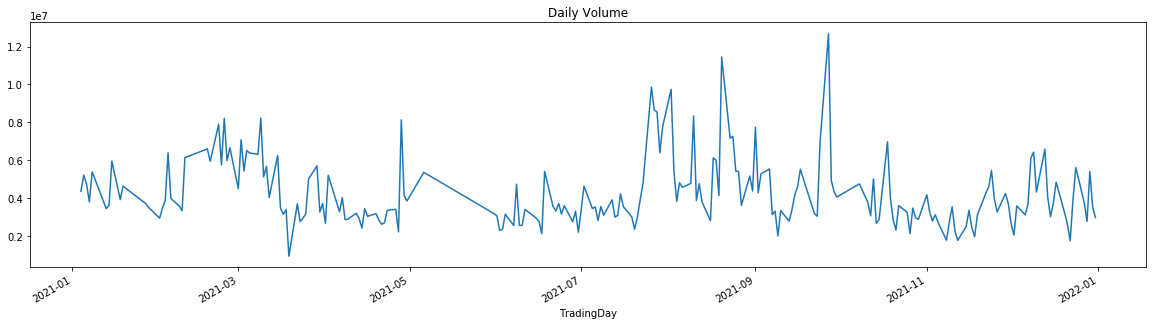

In [6]:
daily_data['Volume'].plot(figsize=(20, 5), title='Daily Volume')

The graph shows that daily trading volume surrounds its median value with mean-reverting effect. 

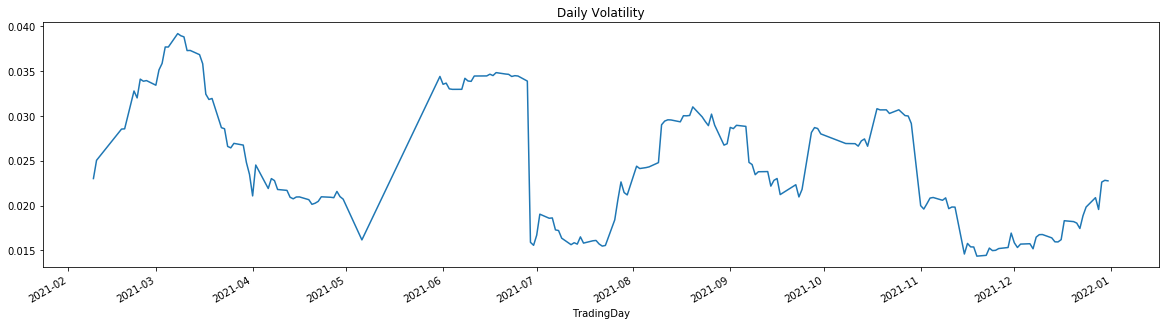

In [7]:
volatility = daily_data['Close'].pct_change().rolling(window=20).std()
volatility.plot(figsize=(20, 5), title='Daily Volatility')

Daily Volatility shows seasonality effect, as the graph indicates.

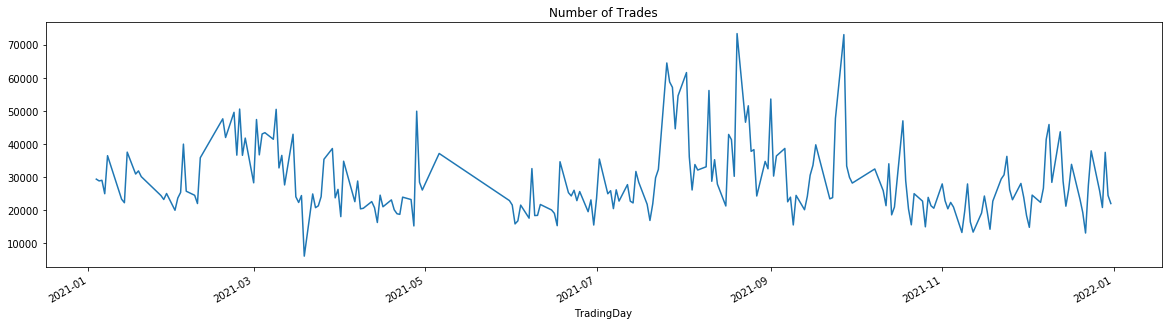

In [8]:
daily_data['TradesCount'].plot(figsize=(20, 5), title='Number of Trades')

From the graph, the trend of the number of trades is similar to the trend of the daily volume, which surrounds its median value with mean-reverting effect.

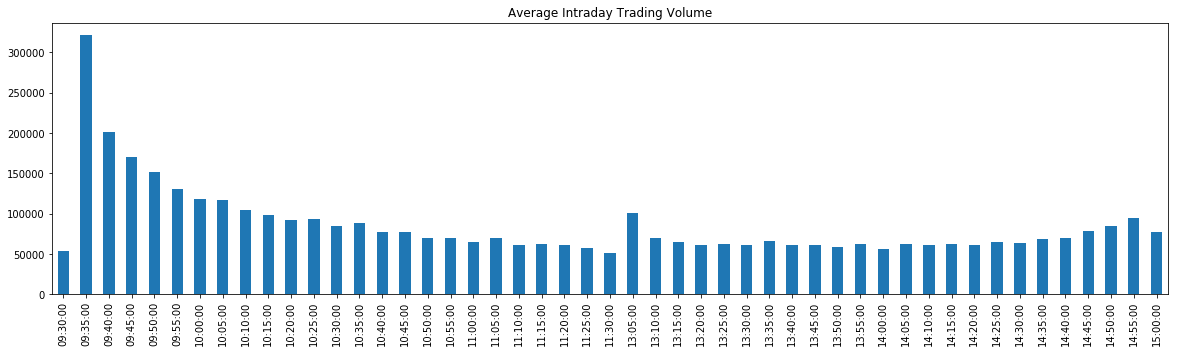

In [6]:
# clean data
df = data[data['Close'] != 0]
df['Time'] = [x.time() for x in df['DataTime']]
df = df[((df['Time'] >= dt.time(9,29,0)) & (df['Time'] <= dt.time(15,0,0))) & ~((df['Time'] > dt.time(11,30,0)) & (df['Time'] <= dt.time(13,0,0)))]
# convert to minute data
df.set_index('DataTime', inplace=True)
df = df.resample('5T', label='right', closed='right').last()
df['Time'] = [x.time() for x in df.index]
# average intraday trading volume
df = df.groupby('Time')['Volume'].mean().dropna()
df = pd.concat([pd.Series([0]), df], axis=0)
df = df.diff().dropna()
# plot
df.plot.bar(figsize=(20, 5), title='Average Intraday Trading Volume')

From the graph of the average intraday trading volume, the market open is the most liquid time of the day and gradually decaying afterwards.

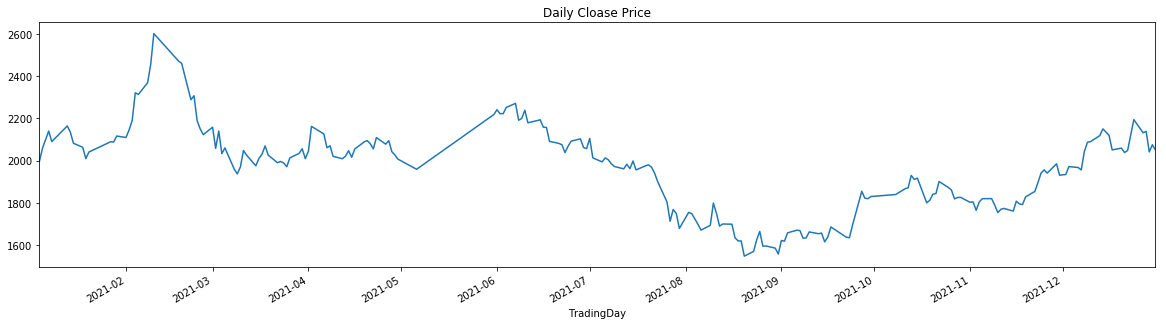

In [7]:
daily_data['Close'].plot(figsize=(20, 5), title='Daily Cloase Price')

From the graph of the daily close price of the stock, it is shown that the stock exbits relatively high return in January-February and September-December periods, and relatively low return in February-March and May-September periods. During periods of extremely high or low return, the volatility of the stock increase accordingly.

In [8]:
data['deltaTurnover'] = data.groupby('TradingDay')['Turnover'].transform(lambda x: x.diff())
data['deltaVolume'] = data.groupby('TradingDay')['Volume'].transform(lambda x: x.diff())
data['deltaTradesCount'] = data.groupby('TradingDay')['TradesCount'].transform(lambda x: x.diff())

In [10]:
data1 = data.copy()

In [11]:
# clean data
# Close: last Traded Price
data_1m = data1[data1['Close'] != 0]
data_1m['Time'] = [x.time() for x in data_1m['DataTime']]
# convert to minute data
data_1m.set_index('DataTime', inplace=True)
data_1m = data_1m.resample('1T', label='right', closed='right').last()
data_1m = data_1m[((data_1m['Time'] >= dt.time(9,29,0)) & (data_1m['Time'] <= dt.time(15,0,0))) & ~((data_1m['Time'] > dt.time(11,30,0)) & (data_1m['Time'] <= dt.time(13,0,0)))]
data_1m['Time'] = [x.time() for x in data_1m.index]

In [12]:
data_1m

,TradingDay,Close,Volume,Turnover,TradesCount,deltaTurnover,deltaVolume,deltaTradesCount,Time
DataTime,,,,,,,,,
2021-01-04 09:30:00,2021-01-04,1998.02,121900.0,2.437971e+08,422.0,799489.0,400.0,4.0,09:30:00
2021-01-04 09:31:00,2021-01-04,1995.00,257649.0,5.145595e+08,1220.0,18708412.1,9400.0,43.0,09:31:00
2021-01-04 09:32:00,2021-01-04,1986.00,329999.0,6.583547e+08,1652.0,2383649.0,1200.0,11.0,09:32:00
2021-01-04 09:33:00,2021-01-04,1995.00,361388.0,7.208212e+08,1863.0,3211403.0,1610.0,16.0,09:33:00
2021-01-04 09:34:00,2021-01-04,1999.00,396719.0,7.913892e+08,2100.0,799659.0,400.0,4.0,09:34:00
...,...,...,...,...,...,...,...,...,...
2021-12-31 14:56:00,2021-12-31,2050.44,2874095.0,5.871994e+09,21542.0,3690797.0,1800.0,9.0,14:56:00
2021-12-31 14:57:00,2021-12-31,2050.95,2899095.0,5.923254e+09,21695.0,410192.0,200.0,2.0,14:57:00
2021-12-31 14:58:00,2021-12-31,2050.95,2899095.0,5.923254e+09,21695.0,0.0,0.0,0.0,14:58:00


## Forecast direction of stock: features and modelling

### 1. feature generation


In [14]:

def addFeatureChange(df, featureCol):
    df[ featureCol + '_prior'] = df[ featureCol].shift(1)
    df[ featureCol + '_diff'] = df[ featureCol] - df[ featureCol + '_prior']
    df[ featureCol + '_diffp'] = (df[ featureCol] +0.00001)/(df[ featureCol + '_prior']+0.00001) -1   
    return df

def addRollingFeature(df, featureCol, window, min_period = 1):
    """
    e.g. 
    window =5: rolling 5 mins stats
    
    """
    meanCol, stdCol, zscoreCol = featureCol + '_' + str(window) +'mmean',featureCol + '_' + str(window) +'mstd',featureCol + '_' + str(window) +'mZscore'
    df[meanCol] =  df.groupby('TradingDay')[featureCol].apply(lambda x: x.rolling(window, min_period).mean())
    df[stdCol] =  df.groupby('TradingDay')[featureCol].apply(lambda x: x.rolling(window, min_period).std())
    df[zscoreCol] =  (df[featureCol] - df[meanCol])/df[stdCol]
    
    return df


def addFeatureVol(df, featureCol, window, min_period = 1):
    """
    e.g. 
    window =5: rolling 5 mins stats
    
    """
    stdCol = featureCol + '_' + str(window) +'mstd'
    df[stdCol] =  df.groupby('TradingDay')[featureCol].apply(lambda x: x.rolling(window, min_period).std())
    
    return df


In [15]:
data_1m['Ret_1m'] = data_1m['Close'].pct_change()
data_1m['Ret_5m'] = data_1m['Close'].pct_change(5)
data_1m['Ret_10m'] = data_1m['Close'].pct_change(10)
data_1m['MA20'] = data_1m['Close'].rolling(window=20).mean()
data_1m['Bias20'] = data_1m['Close'] / data_1m['MA20'] - 1
data_1m['MA10'] = data_1m['Close'].rolling(window=10).mean()
data_1m['Bias10'] = data_1m['Close'] / data_1m['MA10'] - 1
data_1m['MA5'] = data_1m['Close'].rolling(window=5).mean()
data_1m['Bias5'] = data_1m['Close'] / data_1m['MA5'] - 1

In [16]:
featureCols = ['Ret_1m', 'Ret_5m', 'Ret_10m', 'Bias20', 'Bias10', 'Bias5' ] + ['deltaTurnover', 'deltaVolume', 'deltaTradesCount']

In [17]:
for col in featureCols:
    data_1m = addFeatureChange(data_1m, col)

In [18]:
for col in ['Ret_1m','Ret_5m', 'Ret_10m','deltaTurnover', 'deltaVolume', 'deltaTradesCount']:
    data_1m = addRollingFeature(data_1m, col, window = 5)
    data_1m = addRollingFeature(data_1m, col, window = 10)
    data_1m = addRollingFeature(data_1m, col, window = 20)

In [19]:
for col in ['Bias5', 'Bias10', 'Bias20' ]:
    data_1m = addFeatureVol(data_1m, col, window = 5)
    data_1m = addFeatureVol(data_1m, col, window = 10)
    data_1m = addFeatureVol(data_1m, col, window = 20)
 

In [20]:
data_1m.shape

(53004, 108)

### 2. add target: predict 5m return

In [21]:
## add target: predict 5m return
data_1m['target_5mRet'] = data_1m['Ret_5m'].shift(-1)
data_1m['target_10mRet'] = data_1m['Ret_10m'].shift(-1)
data_1m['target_1mRet'] = data_1m['Ret_1m'].shift(-1)

In [22]:
emptyCount = data_1m.isnull().sum(axis = 0)

In [19]:
emptyCount[emptyCount>200] # empty feature values happens at 9:30 when missing look back data

Ret_1m_5mstd                  222
Ret_1m_5mZscore               223
Ret_1m_10mstd                 222
Ret_1m_10mZscore              222
Ret_1m_20mstd                 222
Ret_1m_20mZscore              222
Ret_5m_5mstd                  226
Ret_5m_5mZscore               226
Ret_5m_10mstd                 226
Ret_5m_10mZscore              226
Ret_5m_20mstd                 226
Ret_5m_20mZscore              226
Ret_10m_5mstd                 231
Ret_10m_5mZscore              231
Ret_10m_10mstd                231
Ret_10m_10mZscore             231
Ret_10m_20mstd                231
Ret_10m_20mZscore             231
deltaTurnover_5mstd           221
deltaTurnover_5mZscore        228
deltaTurnover_10mstd          221
deltaTurnover_10mZscore       221
deltaTurnover_20mstd          221
deltaTurnover_20mZscore       221
deltaVolume_5mstd             221
deltaVolume_5mZscore          263
deltaVolume_10mstd            221
deltaVolume_10mZscore         223
deltaVolume_20mstd            221
deltaVolume_20

In [23]:
allCols = data_1m.columns.to_list()

In [ ]:
data_1m['TradingDay'].unique() #: 221 days

### creat label for target col

In [25]:
targetCols =['target_5mRet', 'target_10mRet', 'target_1mRet'] #  ['TradingDay'] + 
data_1m['Label'] = 0
data_1m.loc[data_1m['target_5mRet']>0, 'Label'] = 1
data_1m.loc[data_1m['target_5mRet']<0, 'Label'] = -1

### 3. create train test dataset: use Dec data to test, past data to train and validate

In [24]:
colsToRemove = ['TradingDay', 'Close', 'Volume', 'Turnover', 'TradesCount', 'Time', 'target_5mRet', 'target_10mRet', 'target_1mRet', 'Label'] 

featureCol =  [x for x in allCols if (x not in colsToRemove)] #['TradingDay'] +

In [26]:
allData = data_1m.dropna()

In [27]:
split_date = dt.datetime(2021,12,1)

In [28]:
trainDf = allData[allData['TradingDay']< split_date]
testDf = allData[allData['TradingDay']>= split_date]

In [29]:
allCols = trainDf.columns.to_list()

### 4. preliminary feature selection 

#####  features rank corr with target, filter out those p > 0.05

In [30]:
from scipy.stats import spearmanr

In [31]:
y_train = trainDf['target_5mRet']
x_train = trainDf[featureCol]

In [32]:
pvals = x_train.apply(lambda x: spearmanr(x, y_train)[1])

In [33]:
pvals.sort_values(ascending = False)

deltaTradesCount_diff         0.985744
deltaTradesCount_20mZscore    0.958897
deltaVolume_20mZscore         0.924211
deltaTradesCount_10mstd       0.901162
Ret_10m_10mstd                0.897577
                                ...   
Ret_1m_5mmean                 0.000000
Bias5_prior                   0.000000
Bias10_diff                   0.000000
Bias10_prior                  0.000000
Ret_5m_5mZscore               0.000000
Length: 102, dtype: float64

In [34]:
rank_coef = x_train.apply(lambda x: spearmanr(x, y_train)[0])

In [35]:
rank_coef

deltaTurnover      -0.000722
deltaVolume        -0.002054
deltaTradesCount   -0.004957
Ret_1m              0.403534
Ret_5m              0.753401
                      ...   
Bias10_10mstd       0.008974
Bias10_20mstd      -0.008529
Bias20_5mstd        0.025217
Bias20_10mstd       0.007000
Bias20_20mstd      -0.007584
Length: 102, dtype: float64

In [36]:
spearmanDf = pd.DataFrame(list(zip(featureCol, rank_coef, pvals)), columns = ['feature', 'rankcoef', 'p_value'])

In [38]:
drop_features = spearmanDf[spearmanDf['p_value']>0.05]['feature'].to_list()

In [39]:
len(drop_features)

48

In [41]:
featureCol_filtered =  [x for x in featureCol if (x not in drop_features)] #['TradingDay'] +

In [42]:
featureCol_filtered

['Ret_1m',
 'Ret_5m',
 'Ret_10m',
 'Bias20',
 'Bias10',
 'Bias5',
 'Ret_1m_prior',
 'Ret_1m_diffp',
 'Ret_5m_prior',
 'Ret_5m_diff',
 'Ret_10m_prior',
 'Ret_10m_diff',
 'Bias20_prior',
 'Bias20_diff',
 'Bias20_diffp',
 'Bias10_prior',
 'Bias10_diff',
 'Bias10_diffp',
 'Bias5_prior',
 'Bias5_diff',
 'Bias5_diffp',
 'Ret_1m_5mmean',
 'Ret_1m_5mstd',
 'Ret_1m_5mZscore',
 'Ret_1m_10mmean',
 'Ret_1m_10mZscore',
 'Ret_1m_20mmean',
 'Ret_1m_20mZscore',
 'Ret_5m_5mmean',
 'Ret_5m_5mstd',
 'Ret_5m_5mZscore',
 'Ret_5m_10mmean',
 'Ret_5m_10mZscore',
 'Ret_5m_20mmean',
 'Ret_5m_20mstd',
 'Ret_5m_20mZscore',
 'Ret_10m_5mmean',
 'Ret_10m_5mstd',
 'Ret_10m_5mZscore',
 'Ret_10m_10mmean',
 'Ret_10m_10mZscore',
 'Ret_10m_20mmean',
 'Ret_10m_20mstd',
 'Ret_10m_20mZscore',
 'deltaTurnover_5mmean',
 'deltaTurnover_5mstd',
 'deltaVolume_5mmean',
 'deltaVolume_5mstd',
 'deltaTradesCount_20mmean',
 'deltaTradesCount_20mstd',
 'Bias5_5mstd',
 'Bias5_10mstd',
 'Bias10_5mstd',
 'Bias20_5mstd']

### x, y train test

In [43]:
y_train = trainDf['target_5mRet']
x_train = trainDf[featureCol_filtered]

In [44]:
y_test = testDf['target_5mRet']
x_test = testDf[featureCol_filtered]

### 5. exploratory analysis: relationship of past return and target return prediction

In [190]:
import matplotlib.pyplot as plt

In [200]:
def scatter_plot(df, xcol, ycol):
    plt.scatter(x = df[xcol], y = df[ycol])
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()
    

####  target_5mRet ~ Ret_5m / Ret_1m / Ret_10m

### observations: target_5mRet has linearship with Ret_5m

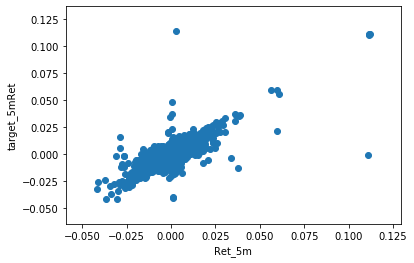

In [201]:
scatter_plot(trainDf,'Ret_5m','target_5mRet' )

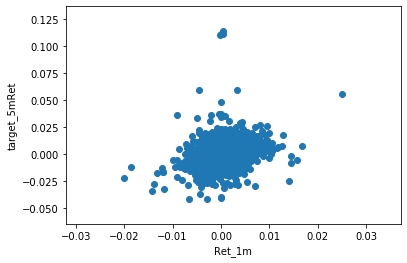

In [205]:
scatter_plot(trainDf,'Ret_1m','target_5mRet' )

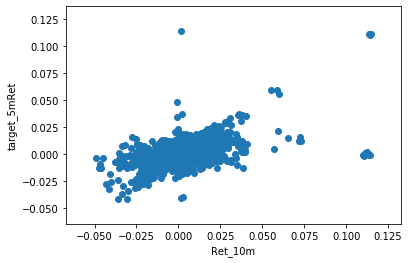

In [203]:
scatter_plot(trainDf,'Ret_10m','target_5mRet' )

#### target x min return ~ x min return

### observations: target 10 min return has linear relationship with Ret_10m

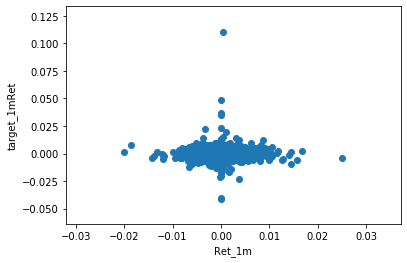

In [206]:
scatter_plot(trainDf,'Ret_1m','target_1mRet' )

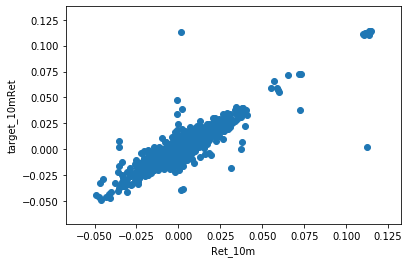

In [207]:
scatter_plot(trainDf,'Ret_10m','target_10mRet' )

### 6. baseline model with LASSO

#### due to linear relationship from plot of 5m return ~ past(prior) 5m return

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
daterange = trainDf['TradingDay'].unique()

In [48]:
len(daterange)

198

In [47]:
def train_test_rolling_split(x_df, y_df, splitDate, endDate):
    x_train, x_validate = x_df[x_df['TradingDay'] <= splitDate], x_df[ (x_df['TradingDay'] > splitDate) &(x_df['TradingDay'] < endDate)]
    y_train, y_validate = y_df[y_df['TradingDay'] <= splitDate], y_df[ (y_df['TradingDay'] > splitDate) &(y_df['TradingDay'] < endDate)]
    for df in [x_train, x_validate, y_train, y_validate]:
        df.drop(columns = ['TradingDay'], axis = 1, inplace = True)
    return x_train, x_validate, y_train, y_validate

#### walk forward validation for time series, roll 20 days for each train-validation pair

In [48]:
def walk_cross_validation_regression(date_range, x_df, y_df, model ):
    r_square = [] # score: r_square for regression, accurarcy for tree
    validation_mse = []
    validation_rsquare = []
    params = []
    for i in range(20, len(date_range)-20, 20):
        splitDate = date_range[i]
        endDate = date_range[i+20]
        x_train, x_validate, y_train, y_validate = train_test_rolling_split(x_df, y_df, splitDate, endDate)
        model.fit(x_train, y_train)
        r_square.append(model.score(x_train, y_train))
        y_pred = model.predict(x_validate)
        validation_rsquare.append(r2_score(y_validate, y_pred)) 
        validation_mse.append(mean_squared_error(y_validate, y_pred))
        params.append(model.get_params())
    return r_square, validation_mse, validation_rsquare, params

#### standardlize all features before lasso

In [49]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_standard= scaler.fit_transform(x_train)
x_train_standard = pd.DataFrame(data = x_train_standard)
x_train_standard.columns = x_train.columns
x_train_standard['TradingDay'] = trainDf['TradingDay'].values

In [50]:
x_train_standard

,Ret_1m,Ret_5m,Ret_10m,Bias20,Bias10,Bias5,Ret_1m_prior,Ret_1m_diffp,Ret_5m_prior,Ret_5m_diff,...,deltaTurnover_5mstd,deltaVolume_5mmean,deltaVolume_5mstd,deltaTradesCount_20mmean,deltaTradesCount_20mstd,Bias5_5mstd,Bias5_10mstd,Bias10_5mstd,Bias20_5mstd,TradingDay
0,-0.004951,-0.136626,-0.206796,0.094181,0.026761,0.250132,0.912702,-0.004604,0.121224,-0.423572,...,-0.284189,-0.366858,-0.299027,0.911344,0.864644,-0.294712,-0.406560,-0.205730,-1.174111,2021-01-04
1,-0.363098,-0.277890,-0.308201,-0.035841,-0.109869,0.056814,-0.004086,-0.004604,-0.132106,-0.230200,...,-0.284208,-0.366858,-0.299027,0.488195,0.295590,-0.328660,-0.512146,-0.341803,-0.895244,2021-01-04
2,-0.001296,0.146110,-0.260120,-0.094920,-0.059777,-0.006171,-0.312387,-0.004604,-0.269450,0.686073,...,-0.286628,-0.400320,-0.301489,0.403565,0.305129,-0.430704,-0.534231,-0.401073,-0.806515,2021-01-04
3,-0.688696,0.001697,-0.193770,-0.329447,-0.394908,-0.599434,-0.000940,-0.004604,0.142785,-0.235303,...,-0.270810,-0.383589,-0.285395,0.318935,0.259802,-0.483685,-0.564438,-0.694774,-0.454384,2021-01-04
4,0.624535,-0.173491,-0.033738,-0.077534,-0.049880,0.012724,-0.592668,-0.004604,0.002379,-0.285189,...,-0.177813,-0.232847,-0.190945,0.371829,0.253463,-0.521520,-0.595488,-0.709191,-0.535410,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47181,-0.303345,-0.106199,-0.191486,-0.065465,-0.235555,0.051549,0.649759,-0.004604,-0.146804,0.072609,...,0.809016,1.172352,0.852244,-0.125372,0.144934,-0.256032,-0.389728,-0.546935,-0.642240,2021-11-30
47182,0.674818,0.453969,-0.171229,0.159378,0.163433,0.439205,-0.260950,-0.004604,-0.102523,0.906796,...,0.595114,0.419477,0.627495,-0.083057,0.125580,-0.485469,-0.442589,-0.415083,-0.582284,2021-11-30
47183,-0.001296,0.149318,-0.194480,0.139156,0.200878,0.374772,0.581073,-0.004604,0.442101,-0.495044,...,0.608456,0.386016,0.641487,-0.104214,0.138329,-0.447287,-0.464625,-0.262506,-0.522326,2021-11-30
47184,-0.001296,0.453969,-0.110964,0.118869,0.222162,0.180249,-0.000940,-0.004604,0.145904,0.492613,...,-0.259863,-0.467242,-0.270415,-0.220580,0.131574,-0.837914,-0.448693,-0.577226,-0.804868,2021-11-30


In [51]:
x_test_standard= scaler.fit_transform(x_test)
x_test_standard = pd.DataFrame(data = x_test_standard)
x_test_standard.columns = x_test.columns
x_test_standard['TradingDay'] = testDf['TradingDay'].values

In [52]:
x_test_standard

,Ret_1m,Ret_5m,Ret_10m,Bias20,Bias10,Bias5,Ret_1m_prior,Ret_1m_diffp,Ret_5m_prior,Ret_5m_diff,...,deltaTurnover_5mstd,deltaVolume_5mmean,deltaVolume_5mstd,deltaTradesCount_20mmean,deltaTradesCount_20mstd,Bias5_5mstd,Bias5_10mstd,Bias10_5mstd,Bias20_5mstd,TradingDay
0,2.152293,3.929672,3.050100,3.212536,4.518161,5.562657,7.199190,0.006806,3.252972,0.924528,...,1.289580,1.281315,1.392634,0.978172,2.250305,-0.940357,-1.026670,-0.004655,0.634151,2021-12-01
1,-2.986046,2.685312,1.948339,1.989689,2.475924,1.772742,1.847089,-0.000961,3.808173,-1.993013,...,0.861812,0.861738,0.939116,0.811986,1.275286,3.013641,2.330061,1.974685,1.543912,2021-12-01
2,-3.911277,1.060830,1.081929,0.499038,0.100112,-2.124222,-2.577485,0.011812,2.601279,-2.603439,...,0.623471,0.861738,0.686579,1.177595,0.999983,5.997994,4.863615,4.842495,4.166853,2021-12-01
3,0.430789,1.640088,0.957899,0.611374,0.147727,-2.443089,-3.374193,0.005040,1.025709,0.935481,...,0.493516,0.973625,0.549342,1.476730,0.863456,6.502625,5.292019,5.147212,4.349031,2021-12-01
4,0.863774,-1.438686,1.302522,0.854013,0.366767,-1.078560,0.364718,0.014993,1.587525,-4.938845,...,0.752452,2.092497,0.829067,1.842339,0.923367,5.477140,4.888675,4.773582,4.124603,2021-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5500,0.005558,0.101639,0.379798,0.509311,0.167246,0.072428,0.171622,0.005941,0.221827,-0.204065,...,-0.047588,-0.089303,-0.043856,-0.447705,-0.683638,-1.128711,-0.873837,-1.009151,-0.982736,2021-12-31
5501,0.382816,0.245420,0.479569,0.578554,0.281109,0.299334,-0.001444,0.118364,0.095397,0.236162,...,0.033517,0.171767,0.037895,-0.377907,-0.608544,-1.036410,-0.879349,-1.053750,-1.028694,2021-12-31
5502,0.206393,0.228431,0.316806,0.580036,0.329552,0.378521,0.323409,0.008204,0.234849,-0.022014,...,0.071256,0.097175,0.076011,-0.387878,-0.602631,-0.945654,-0.901719,-1.108226,-1.209750,2021-12-31
5503,-0.002643,0.318146,0.142798,0.499655,0.296829,0.235859,0.171493,0.005762,0.218371,0.149339,...,0.003984,-0.238486,0.007982,-0.397849,-0.587205,-0.991294,-1.099371,-1.119257,-1.162683,2021-12-31


In [53]:
y_train = pd.DataFrame( trainDf['target_5mRet'].values, columns = ['target_5mRet'])
y_train['TradingDay'] = trainDf['TradingDay'].values

In [54]:
y_test = pd.DataFrame( testDf['target_5mRet'].values, columns = ['target_5mRet'])
y_test['TradingDay'] = testDf['TradingDay'].values

#### grid search for lasso parameters

In [352]:
alphas = 10**np.linspace(-4,-10,20)*0.5

In [354]:
alphas

array([5.00000000e-05, 2.41646512e-05, 1.16786073e-05, 5.64418946e-06,
       2.72779739e-06, 1.31832545e-06, 6.37137493e-07, 3.07924106e-07,
       1.48817572e-07, 7.19224944e-08, 3.47596398e-08, 1.67990914e-08,
       8.11888370e-09, 3.92379985e-09, 1.89634510e-09, 9.16490355e-10,
       4.42933395e-10, 2.14066620e-10, 1.03456904e-10, 5.00000000e-11])

In [ ]:
lasso = Lasso(max_iter=500000, normalize=True)
coefs = []
result_validation_rsquare = {}
result_r_square = {}
result_coefs = {}

for a in alphas:
    lasso.set_params(alpha=a)
    r_square, validation_mse, validation_rsquare, params = walk_cross_validation_regression(daterange, x_train_standard, y_train, model = lasso )
    coefs.append(lasso.coef_)
    result_validation_rsquare[a] = validation_rsquare
    result_r_square[a] = r_square
    result_coefs[a] = params


In [360]:
result_r_square

{5e-05: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 2.4164651192858762e-05: [0.40722769819912263,
  0.2826967254893422,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 1.1678607345450606e-05: [0.6319208843618037,
  0.6137251502950314,
  0.5350127123892076,
  0.48241003557334844,
  0.38919947106195973,
  0.33469551800335107,
  0.27646561941321257,
  0.22453459880093096],
 5.644189458423442e-06: [0.684443568414969,
  0.6936430086330174,
  0.6746057301026415,
  0.6514124803170531,
  0.6281342375333361,
  0.623109144352098,
  0.6071491462006517,
  0.5980799665032308],
 2.727797390584257e-06: [0.6973037642152071,
  0.7123111403172885,
  0.7072129907216718,
  0.6908873130399623,
  0.6839464404551756,
  0.69095932400925,
  0.6860284549799582,
  0.6877998768431476],
 1.3183254493651777e-06: [0.7234252732651788,
  0.7395208750627509,
  0.7293275528469634,
  0.7102639497993105,
  0.6986819519843952,
  0.7068087179121828,
  0.7044539675841578,
  0.7087564486782963],
 6.371374928515674e-07: [0.72969931

In [359]:
result_validation_rsquare

{5e-05: [-0.009557243254644021,
  -0.00010146168266955691,
  -0.0005704565982942444,
  -0.0017376231243446671,
  -0.0013998949162823404,
  -0.0002832447437852714,
  -0.002101331383716598,
  -3.857457975264822e-08],
 2.4164651192858762e-05: [0.42541621644085104,
  0.28712841031098035,
  -0.0005704565982942444,
  -0.0017376231243446671,
  -0.0013998949162823404,
  -0.0002832447437852714,
  -0.002101331383716598,
  -3.857457975264822e-08],
 1.1678607345450606e-05: [0.6587471636636943,
  0.6191565740939944,
  0.48065492500609,
  0.4859107401686775,
  0.4310748395173192,
  0.3413565798063838,
  0.2916368046360369,
  0.23311642389508858],
 5.644189458423442e-06: [0.7127344188566493,
  0.6965727652352542,
  0.620000119698978,
  0.6443058369708919,
  0.6927290644657274,
  0.6220770359399967,
  0.638772961585941,
  0.6154264625992645],
 2.727797390584257e-06: [0.7256806751549074,
  0.7131624636963403,
  0.6542549612096675,
  0.6777812975156672,
  0.7562870414763704,
  0.6833828968753134,
  0.72

#### choose alpha: 1.4881757208156595e-07

In [379]:
lasso= Lasso(max_iter=500000, alpha= 1.4881757208156595e-07, normalize=True)

In [373]:
r_square, validation_mse, validation_rsquare, params = walk_cross_validation(daterange, x_train_standard, y_train, model = lasso )

In [374]:
r_square

[0.7335199492461875,
 0.7523373345706079,
 0.7508947787410695,
 0.7373199216242601,
 0.7355460596145078,
 0.7443690346286993,
 0.7451451185283072,
 0.7489755835394214]

In [385]:
lasso.fit(x_train_standard.drop('TradingDay', axis =1), y_train.drop('TradingDay', axis =1))
r2_train_lasso = lasso.score(x_train_standard.drop('TradingDay', axis =1), y_train.drop('TradingDay', axis =1))
y_pred_Lasso = lasso.predict(x_test_standard.drop('TradingDay', axis =1))
r2_pred_lasso = r2_score(y_test.drop('TradingDay', axis =1), y_pred_Lasso)


#### lasso result: 0.72 r^2 on testing set (last 20 days)

In [386]:
r2_train_lasso, r2_pred_lasso

(0.750507016367219, 0.7229245766919192)

### lasso feature importance is represented by coefficient

In [388]:
coef_lasso = list(lasso.coef_)

In [398]:
coef_lassoDf = pd.DataFrame({'feature':featureCol_filtered, 'coef':coef_lasso})

In [399]:
coef_lassoDf[coef_lassoDf['coef']!=0]

,feature,coef
5,Bias5,0.001901
6,Ret_1m_prior,-0.000911
18,Bias5_prior,0.001830
23,Ret_1m_5mZscore,0.000048
46,deltaVolume_5mmean,0.000014
47,deltaVolume_5mstd,0.000014


In [410]:
features_lasso = coef_lassoDf[coef_lassoDf['coef']!=0]
features_lasso['importance'] = np.abs(features_lasso['coef'])
features_lasso.sort_values('importance', ascending = False)

,feature,coef,importance
5,Bias5,0.001901,0.001901
18,Bias5_prior,0.001830,0.001830
6,Ret_1m_prior,-0.000911,0.000911
23,Ret_1m_5mZscore,0.000048,0.000048
46,deltaVolume_5mmean,0.000014,0.000014
47,deltaVolume_5mstd,0.000014,0.000014


### Conclusion: 
#### In lasso model,  Bias5, Bias5_prior, Ret_1m_prior are top 3 importance features to predict next 5 min return

#### data_1m['Bias5'] = data_1m['Close'] / data_1m['MA5'] - 1

### lasso model feature corr
#### bias5 is highly correlated with Bias5_prior (0.71)

<function matplotlib.pyplot.show(*args, **kw)>

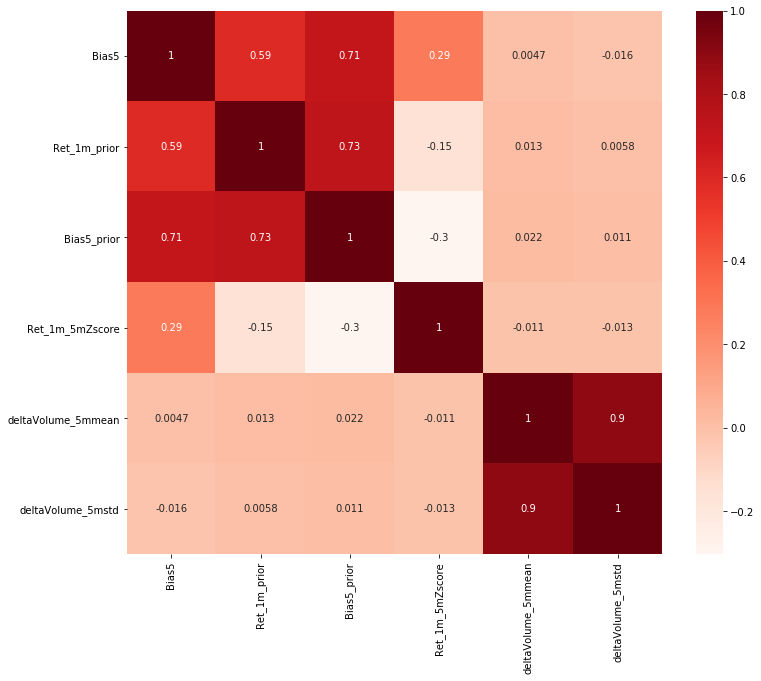

In [413]:
import seaborn as sns
plt.figure(figsize = (12,10))
corr = x_train_standard[features_lasso['feature']].corr()
sns.heatmap(corr, annot = True, cmap = plt.cm.Reds)
plt.show()

### 7. classification model to predict return direction

#### imbalance data issue: use weighted f1 score for evaluation

In [55]:
trainDf.groupby(['Label'])['Label'].count()

Label
-1    24169
 0      471
 1    22546
Name: Label, dtype: int64

In [57]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

In [56]:
def walk_cross_validation_classification(date_range, x_df, y_df, model ):
    train_accurarcy = [] # score: r_square for regression, accurarcy for tree
    train_f1_macro=[]
    validation_f1_macro = []
    train_f1_weighted=[]
    validation_f1_weighted = []
    train_f1_all=[]
    validation_f1_all = []
    validation_accurarcy = []
    params = []
    for i in range(20, len(date_range)-20, 20):
        splitDate = date_range[i]
        endDate = date_range[i+20]
        x_train, x_validate, y_train, y_validate = train_test_rolling_split(x_df, y_df, splitDate, endDate)
        model.fit(x_train, y_train)
        
        train_accurarcy.append(model.score(x_train, y_train))
        
        y_train_pred = model.predict(x_train)
        train_f1_macro.append(f1_score(y_train_pred, y_train, average = 'macro'))
        train_f1_weighted.append(f1_score(y_train_pred, y_train, average = 'weighted'))
        train_f1_all.append(f1_score(y_train_pred, y_train, average = None))
        
        y_pred = model.predict(x_validate)
        validation_accurarcy.append(accuracy_score(y_validate, y_pred)) 
        validation_f1_macro.append(f1_score(y_pred, y_validate, average = 'macro'))
        validation_f1_weighted.append(f1_score(y_pred, y_validate, average = 'weighted'))
        validation_f1_all.append(f1_score(y_pred, y_validate, average = None))
        
        params.append(model.get_params())
        
    return train_accurarcy, validation_accurarcy,train_f1_macro, validation_f1_macro, train_f1_weighted, validation_f1_weighted, train_f1_all, validation_f1_all, params

In [59]:
x_train = x_train.reset_index(drop = True)
x_train['TradingDay'] = trainDf['TradingDay'].values

In [60]:
y_train_tree = pd.DataFrame( trainDf['Label'].values, columns = ['Label_5mRet'])
y_train_tree['TradingDay'] = trainDf['TradingDay'].values

In [61]:
x_test = x_test.reset_index(drop = True)
x_test['TradingDay'] = testDf['TradingDay'].values

In [62]:
y_test_tree = pd.DataFrame( testDf['Label'].values, columns = ['Label_5mRet'])
y_test_tree['TradingDay'] = testDf['TradingDay'].values

### 8.  baseline: decision tree classification

In [58]:
from sklearn.tree import DecisionTreeClassifier

#### grid search on hyperparameters

In [68]:
params = []
train_accurarcy ={}
train_f1_macro={}
train_f1_weighted={}
train_f1_all={}
validation_f1_macro ={}
validation_f1_weighted ={}
validation_f1_all ={}
validation_accurarcy = {}
#n_estimators = [50, 100, 150, 200]
#max_depth = [2, 4, 6, 8]
# min_samples_leaf=20
#for estimator in [50, 75, 100, 120, 150, 175]:
for max_depth in [ 4, 5, 6, 7, 8]:
    for min_samples_split in np.linspace(0.1, 1.0, 10, endpoint=True):
        params.append(( max_depth, min_samples_split ))
        tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=max_depth,min_samples_split = min_samples_split)
        trainAccurarcy, validationAccurarcy, trainF1_macro, validationF1_macro, trainF1_weighted, validationF1_weighted, trainF1_all, validationF1_all, params_ = walk_cross_validation_classification(daterange, x_train, y_train_tree, model = tree) 
        
        train_accurarcy[( max_depth, min_samples_split )] = trainAccurarcy
        validation_accurarcy[( max_depth, min_samples_split )] = validationAccurarcy
        
        train_f1_macro[( max_depth, min_samples_split )] = trainF1_macro
        validation_f1_macro[( max_depth, min_samples_split )] = validationF1_macro
        
        train_f1_weighted[( max_depth, min_samples_split )] = trainF1_weighted
        validation_f1_weighted[( max_depth, min_samples_split )] = validationF1_weighted

        train_f1_all[( max_depth, min_samples_split )] = trainF1_all
        validation_f1_all[( max_depth, min_samples_split )] = validationF1_all

    

In [80]:
#accurarcy: micro f1

In [77]:
train_accurarcy

{(4, 0.1): [0.8189070602313522,
  0.8214795190544121,
  0.8236397748592871,
  0.8167998746278012,
  0.8175399013955043,
  0.8183685548166975,
  0.8213710399140862,
  0.8199258717895176],
 (4, 0.2): [0.7929796569605105,
  0.8058895455471775,
  0.8038357306649989,
  0.801023872956172,
  0.7983621626138547,
  0.798663092295373,
  0.8030547103394785,
  0.801289413238672],
 (4, 0.30000000000000004): [0.7929796569605105,
  0.8058895455471775,
  0.8038357306649989,
  0.801023872956172,
  0.7983621626138547,
  0.798663092295373,
  0.8030547103394785,
  0.801289413238672],
 (4, 0.4): [0.7929796569605105,
  0.8058895455471775,
  0.8038357306649989,
  0.801023872956172,
  0.7983621626138547,
  0.798663092295373,
  0.8030547103394785,
  0.801289413238672],
 (4, 0.5): [0.7929796569605105,
  0.8058895455471775,
  0.8038357306649989,
  0.801023872956172,
  0.7983621626138547,
  0.798663092295373,
  0.8030547103394785,
  0.801289413238672],
 (4, 0.6): [0.7929796569605105,
  0.8058895455471775,
  0.803

In [73]:
validation_accurarcy

{(4, 0.1): [0.8368421052631579,
  0.7978796957824383,
  0.8087322695035462,
  0.8000439463854098,
  0.8201802593976698,
  0.8403158587409519,
  0.8142857142857143,
  0.8036419482229048],
 (4, 0.2): [0.8098684210526316,
  0.7948836137358839,
  0.7905585106382979,
  0.7890573500329597,
  0.7973180918883271,
  0.8271550778679535,
  0.7887912087912088,
  0.7942079859587539],
 (4, 0.30000000000000004): [0.8098684210526316,
  0.7948836137358839,
  0.7905585106382979,
  0.7890573500329597,
  0.7973180918883271,
  0.8271550778679535,
  0.7887912087912088,
  0.7942079859587539],
 (4, 0.4): [0.8098684210526316,
  0.7948836137358839,
  0.7905585106382979,
  0.7890573500329597,
  0.7973180918883271,
  0.8271550778679535,
  0.7887912087912088,
  0.7942079859587539],
 (4, 0.5): [0.8098684210526316,
  0.7948836137358839,
  0.7905585106382979,
  0.7890573500329597,
  0.7973180918883271,
  0.8271550778679535,
  0.7887912087912088,
  0.7942079859587539],
 (4, 0.6): [0.8098684210526316,
  0.7948836137358

In [79]:
train_f1_all

{(4, 0.1): [array([0.82157842, 0.        , 0.82378943]),
  array([0.83268558, 0.        , 0.81541451]),
  array([0.83028935, 0.        , 0.82404901]),
  array([0.81654696, 0.        , 0.82488126]),
  array([0.82267964, 0.        , 0.82080095]),
  array([0.82497759, 0.        , 0.81990269]),
  array([0.82882247, 0.        , 0.82183064]),
  array([0.82521864, 0.        , 0.82266438])],
 (4, 0.2): [array([0.7743957 , 0.        , 0.81465361]),
  array([0.81049207, 0.        , 0.80720165]),
  array([0.81142779, 0.        , 0.80307999]),
  array([0.8083854 , 0.        , 0.80145214]),
  array([0.80612875, 0.        , 0.79866347]),
  array([0.8081014 , 0.        , 0.79691331]),
  array([0.81332175, 0.        , 0.80019884]),
  array([0.81117353, 0.        , 0.79887284])],
 (4, 0.30000000000000004): [array([0.7743957 , 0.        , 0.81465361]),
  array([0.81049207, 0.        , 0.80720165]),
  array([0.81142779, 0.        , 0.80307999]),
  array([0.8083854 , 0.        , 0.80145214]),
  array([0.8

In [71]:
validation_f1_all

{(4, 0.1): [array([0.85792031, 0.        , 0.81468354]),
  array([0.81108647, 0.        , 0.79271845]),
  array([0.81625442, 0.        , 0.81217587]),
  array([0.798627  , 0.        , 0.81077614]),
  array([0.83368157, 0.        , 0.81273408]),
  array([0.85498057, 0.        , 0.83122464]),
  array([0.81917018, 0.        , 0.81786186]),
  array([0.81035996, 0.        , 0.80576497])],
 (4, 0.2): [array([0.82065332, 0.        , 0.80275862]),
  array([0.79459203, 0.        , 0.80380607]),
  array([0.79903254, 0.        , 0.79275198]),
  array([0.79697297, 0.        , 0.79059249]),
  array([0.81353135, 0.        , 0.78622328]),
  array([0.844838  , 0.        , 0.81382331]),
  array([0.79624372, 0.        , 0.78945016]),
  array([0.80496151, 0.        , 0.79179954])],
 (4, 0.30000000000000004): [array([0.82065332, 0.        , 0.80275862]),
  array([0.79459203, 0.        , 0.80380607]),
  array([0.79903254, 0.        , 0.79275198]),
  array([0.79697297, 0.        , 0.79059249]),
  array([0.8

In [78]:
train_f1_weighted

{(4, 0.1): [0.8226508539374289,
  0.8246818270910136,
  0.827228369867031,
  0.8210247468036393,
  0.8217310295589778,
  0.8224395197300307,
  0.8253413668689825,
  0.8239118431562223],
 (4, 0.2): [0.7982340999765597,
  0.8088143359978344,
  0.807340032786454,
  0.8049682059159852,
  0.8024616120597303,
  0.8026715396272581,
  0.806984215380308,
  0.8052135760194826],
 (4, 0.30000000000000004): [0.7982340999765597,
  0.8088143359978344,
  0.807340032786454,
  0.8049682059159852,
  0.8024616120597303,
  0.8026715396272581,
  0.806984215380308,
  0.8052135760194826],
 (4, 0.4): [0.7982340999765597,
  0.8088143359978344,
  0.807340032786454,
  0.8049682059159852,
  0.8024616120597303,
  0.8026715396272581,
  0.806984215380308,
  0.8052135760194826],
 (4, 0.5): [0.7982340999765597,
  0.8088143359978344,
  0.807340032786454,
  0.8049682059159852,
  0.8024616120597303,
  0.8026715396272581,
  0.806984215380308,
  0.8052135760194826],
 (4, 0.6): [0.7982340999765597,
  0.8088143359978344,
  0.

In [76]:
validation_f1_weighted

{(4, 0.1): [0.839886028038321,
  0.8026877265518236,
  0.8142567262392587,
  0.8052661809048207,
  0.8236844293944061,
  0.8439285104533135,
  0.8185042288633564,
  0.8080060112485223],
 (4, 0.2): [0.8116196359143928,
  0.7994294550947161,
  0.7959841317203851,
  0.793843719327205,
  0.8008708276020672,
  0.8309531603648971,
  0.7928932247246746,
  0.7985653353260607],
 (4, 0.30000000000000004): [0.8116196359143928,
  0.7994294550947161,
  0.7959841317203851,
  0.793843719327205,
  0.8008708276020672,
  0.8309531603648971,
  0.7928932247246746,
  0.7985653353260607],
 (4, 0.4): [0.8116196359143928,
  0.7994294550947161,
  0.7959841317203851,
  0.793843719327205,
  0.8008708276020672,
  0.8309531603648971,
  0.7928932247246746,
  0.7985653353260607],
 (4, 0.5): [0.8116196359143928,
  0.7994294550947161,
  0.7959841317203851,
  0.793843719327205,
  0.8008708276020672,
  0.8309531603648971,
  0.7928932247246746,
  0.7985653353260607],
 (4, 0.6): [0.8116196359143928,
  0.7994294550947161,


#### choose max_depth=4,min_samples_split = 0.1

#### split by gini 

In [93]:
tree_gini = DecisionTreeClassifier( max_depth=4,min_samples_split = 0.1)

In [93]:
tree_gini.fit(x_train.drop('TradingDay', axis = 1), y_train_tree.drop('TradingDay', axis = 1))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [94]:
y_pred_tree = tree_gini.predict(x_test.drop('TradingDay', axis =1))

In [98]:
accuracy = accuracy_score(y_test_tree.drop('TradingDay', axis =1), y_pred_tree)

In [99]:
accuracy

0.8096276112624886

In [100]:
cm=confusion_matrix(y_test_tree.drop('TradingDay', axis =1),y_pred_tree)

In [101]:
cm

array([[2308,    0,  464],
       [  28,    0,   28],
       [ 528,    0, 2149]])

In [103]:
print(classification_report(y_test_tree.drop('TradingDay', axis =1),y_pred_tree, target_names=['1', '0', '-1']))

              precision    recall  f1-score   support

           1       0.81      0.83      0.82      2772
           0       0.00      0.00      0.00        56
          -1       0.81      0.80      0.81      2677

    accuracy                           0.81      5505
   macro avg       0.54      0.55      0.54      5505
weighted avg       0.80      0.81      0.81      5505



#### split by entropy

In [104]:
tree_entropy = DecisionTreeClassifier( criterion='entropy', max_depth=4,min_samples_split = 0.1)
tree_entropy.fit(x_train.drop('TradingDay', axis = 1), y_train_tree.drop('TradingDay', axis = 1))
y_pred_entropy_tree = tree_entropy.predict(x_test.drop('TradingDay', axis =1))

In [105]:
accuracy_entropy = accuracy_score(y_test_tree.drop('TradingDay', axis =1), y_pred_entropy_tree)

In [106]:
accuracy_entropy

0.8034514078110808

In [107]:
cm=confusion_matrix(y_test_tree.drop('TradingDay', axis =1),y_pred_entropy_tree)

In [108]:
cm

array([[2236,    0,  536],
       [  28,    0,   28],
       [ 490,    0, 2187]])

In [109]:
print(classification_report(y_test_tree.drop('TradingDay', axis =1),y_pred_entropy_tree, target_names=['1', '0', '-1']))

              precision    recall  f1-score   support

           1       0.81      0.81      0.81      2772
           0       0.00      0.00      0.00        56
          -1       0.79      0.82      0.81      2677

    accuracy                           0.80      5505
   macro avg       0.54      0.54      0.54      5505
weighted avg       0.80      0.80      0.80      5505



/Users/bella/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
y_train_tree.groupby('Label_5mRet').count()

,TradingDay
Label_5mRet,
-1,24169
0,471
1,22546


In [117]:
set(y_pred_entropy_tree)# --> no 0 prediction from training dataset

{-1, 1}

### Conclusion: 
#### From decision tree model , we can get a 0.8 weighted F1 score. for both label 1(positive return) and label -1 (negative return), the F1 score hit 0.8 on testing set; however, the model is affected ny imbalance data, the label 0 (0 return) is not correctedly predicted from training dataset.

#### possoble solution: 1. oversample minority (label 0) 2. emsamble tree: random forest

### decition tree feature importance

In [82]:
features = x_train.drop('TradingDay', axis = 1).columns.to_list()

#### 1. sklearn importance: mean decrease impurity ( Gini importance )

cons: 1. prefer features with high cardinality 2. for correlated features it can select one of the feature and neglect the importance of the second one 

In [121]:
treeFeatureImportance = pd.DataFrame({'feature': features, 'importance_sklearn':tree_gini.feature_importances_})

treeFeatureImportance.sort_values(by = 'importance_sklearn', ascending = False).head(7)

#### 2. permutation importance: overcome drawbacks of mean decrease impurity

In [79]:
from sklearn.inspection import permutation_importance

In [128]:
perm_importance = permutation_importance(tree_gini, x_test.drop('TradingDay', axis =1), y_test_tree.drop('TradingDay', axis =1))

In [131]:
treeFeatureImportance_perm = pd.DataFrame({'feature': features, 'importance_perm':perm_importance.importances_mean})

In [133]:
treeFeatureImportance_perm.sort_values(by = 'importance_perm', ascending = False).head(7)

,feature,importance_perm
5,Bias5,0.075858
18,Bias5_prior,0.029319
1,Ret_5m,0.016312
40,Ret_10m_10mZscore,0.000000
30,Ret_5m_5mZscore,0.000000
31,Ret_5m_10mmean,0.000000
32,Ret_5m_10mZscore,0.000000


### Conclusion
#### from decicition tree model, it's shown that Bias5, Bias5_prior, Ret_5m are important features; 
#### In particular, Ret_5m is past 5m return, has predictive power of future 5m return direction

### 9. RandomForestClassifier

In [64]:
from sklearn.ensemble import RandomForestClassifier
#rfc = RandomForestClassifier()

#### grid search

In [ ]:
params = []
train_accurarcy ={}
train_f1_macro={}
train_f1_weighted={}
train_f1_all={}
validation_f1_macro ={}
validation_f1_weighted ={}
validation_f1_all ={}
validation_accurarcy = {}
#n_estimators = [50, 100, 150, 200]
#max_depth = [2, 4, 6, 8]
# min_samples_leaf=20
for estimator in [25, 50, 75, 100, 120, 150, 175]:
    for max_depth in [ 4, 5, 6, 7]:
        for min_samples_split in np.linspace(0.1, 0.5, 5, endpoint=True):
            params.append(( estimator,max_depth, min_samples_split ))
            rfc = RandomForestClassifier(n_estimators = estimator,max_depth=max_depth,min_samples_split = min_samples_split)
            trainAccurarcy, validationAccurarcy, trainF1_macro, validationF1_macro, trainF1_weighted, validationF1_weighted, trainF1_all, validationF1_all, params_ = walk_cross_validation_classification(daterange, x_train, y_train_tree, model = rfc) 

            train_accurarcy[( estimator,max_depth, min_samples_split )] = trainAccurarcy
            validation_accurarcy[( estimator, max_depth, min_samples_split )] = validationAccurarcy

            train_f1_macro[( estimator, max_depth, min_samples_split )] = trainF1_macro
            validation_f1_macro[( estimator, max_depth, min_samples_split )] = validationF1_macro

            train_f1_weighted[( estimator, max_depth, min_samples_split )] = trainF1_weighted
            validation_f1_weighted[( estimator, max_depth, min_samples_split )] = validationF1_weighted

            train_f1_all[(estimator, max_depth, min_samples_split )] = trainF1_all
            validation_f1_all[( estimator, max_depth, min_samples_split )] = validationF1_all

In [69]:
validation_f1_all

{(25, 4, 0.1): [array([0.84443558, 0.        , 0.81058564]),
  array([0.82352941, 0.        , 0.81472684]),
  array([0.81486368, 0.        , 0.80996602]),
  array([0.81281108, 0.        , 0.804338  ]),
  array([0.83391216, 0.        , 0.8037473 ]),
  array([0.85191083, 0.        , 0.81746423]),
  array([0.8141783 , 0.        , 0.80263756]),
  array([0.81378731, 0.        , 0.79619313])],
 (25, 4, 0.2): [array([0.84501992, 0.        , 0.81030675]),
  array([0.81445672, 0.        , 0.81054596]),
  array([0.81955556, 0.        , 0.81828367]),
  array([0.80885831, 0.        , 0.79845314]),
  array([0.82927827, 0.        , 0.79913607]),
  array([0.84296532, 0.        , 0.80738916]),
  array([0.81014304, 0.        , 0.80153188]),
  array([0.81714527, 0.        , 0.80046189])],
 (25, 4, 0.30000000000000004): [array([0.83402245, 0.        , 0.79133466]),
  array([0.8032596 , 0.        , 0.80276817]),
  array([0.79638826, 0.        , 0.80079418]),
  array([0.81425811, 0.        , 0.80273349]),


In [68]:
validation_f1_weighted

{(25, 4, 0.1): [0.8293441489696691,
  0.8193218680757204,
  0.8124864918059322,
  0.8086480826019988,
  0.8202388344315589,
  0.8369051386186533,
  0.8086793303449834,
  0.8055537868246733],
 (25, 4, 0.2): [0.8295893064272883,
  0.8125189181880105,
  0.8189246846543342,
  0.8038146258315834,
  0.8155887126342313,
  0.8274207503099004,
  0.8059623689572033,
  0.8092574518476997],
 (25, 4, 0.30000000000000004): [0.8155992964753044,
  0.8030105439503116,
  0.7986419963265509,
  0.8086869863354642,
  0.819246978349069,
  0.8313726810077211,
  0.8006128947543797,
  0.8038494810532373],
 (25, 4, 0.4): [0.8210545284535781,
  0.8030717058085769,
  0.7921588364651956,
  0.7926499662754581,
  0.8017330648145212,
  0.8202104556597426,
  0.7916735318629549,
  0.8046993956582299],
 (25, 4, 0.5): [0.8175594486254576,
  0.8051204169691131,
  0.8018004850290588,
  0.7932027039371445,
  0.810230391899378,
  0.8238309724155626,
  0.8007160682044933,
  0.7879733266362943],
 (25, 5, 0.1): [0.8353841098825

In [70]:
train_f1_weighted

{(25, 4, 0.1): [0.8151111678605086,
  0.8284459864499907,
  0.8181207134264984,
  0.8174736761707695,
  0.8195599072034498,
  0.8178768786027507,
  0.8173243643743018,
  0.813913664358338],
 (25, 4, 0.2): [0.8140503481813562,
  0.8177753754257001,
  0.8234650702661402,
  0.8126821537031208,
  0.8147006005270777,
  0.8114682011040243,
  0.8144650003908023,
  0.8165292928048451],
 (25, 4, 0.30000000000000004): [0.8036216105446157,
  0.8117948157191096,
  0.8103190368902571,
  0.8166032641247353,
  0.8202612109195239,
  0.8106251465285794,
  0.8100764020836977,
  0.8122134126262537],
 (25, 4, 0.4): [0.8033216636349508,
  0.815684669748248,
  0.7975782331250019,
  0.8019000644438804,
  0.8045953535958277,
  0.8019479789887336,
  0.804806139433322,
  0.8085866624236322],
 (25, 4, 0.5): [0.80472549657793,
  0.8136148721943722,
  0.8122440139765845,
  0.7999737754064987,
  0.8086597766055951,
  0.8065934752242598,
  0.8099687000600034,
  0.7986340420403537],
 (25, 5, 0.1): [0.8214927154494271

####  choose  estimator = 25,max_depth =6, min_samples_split = 0.1

In [ ]:
rfc = RandomForestClassifier( n_estimators = 25,max_depth =6, min_samples_split = 0.1)
rfc.fit(x_train.drop('TradingDay', axis = 1), y_train_tree.drop('TradingDay', axis = 1))
y_pred_rfc = rfc.predict(x_test.drop('TradingDay', axis =1))

In [73]:
accuracy_rfc = accuracy_score(y_test_tree.drop('TradingDay', axis =1), y_pred_rfc)

In [74]:
accuracy_rfc

0.808174386920981

In [75]:
cm=confusion_matrix(y_test_tree.drop('TradingDay', axis =1),y_pred_rfc)

In [77]:
cm

array([[2336,    0,  436],
       [  34,    0,   22],
       [ 564,    0, 2113]])

In [76]:
print(classification_report(y_test_tree.drop('TradingDay', axis =1),y_pred_rfc, target_names=['1', '0', '-1']))

              precision    recall  f1-score   support

           1       0.80      0.84      0.82      2772
           0       0.00      0.00      0.00        56
          -1       0.82      0.79      0.81      2677

    accuracy                           0.81      5505
   macro avg       0.54      0.54      0.54      5505
weighted avg       0.80      0.81      0.80      5505



/Users/bella/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bella/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bella/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
perm_importance = permutation_importance(rfc, x_test.drop('TradingDay', axis =1), y_test_tree.drop('TradingDay', axis =1))

In [83]:
rfcFeatureImportance_perm = pd.DataFrame({'feature': features, 'importance_perm':perm_importance.importances_mean})

#### negative values for permutation importances means the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 
#### This happens when the feature doesn't matter, but random chance caused the predictions on shuffled data to be more accurate. 
#### This is more common with small datasets


In [85]:
rfcFeatureImportance_perm.sort_values(by = 'importance_perm', ascending = False)

,feature,importance_perm
5,Bias5,4.748411e-02
35,Ret_5m_20mZscore,4.287012e-03
1,Ret_5m,4.214351e-03
30,Ret_5m_5mZscore,3.051771e-03
21,Ret_1m_5mmean,2.724796e-03
3,Bias20,2.688465e-03
18,Bias5_prior,2.470481e-03
20,Bias5_diffp,1.671208e-03
4,Bias10,1.271571e-03
32,Ret_5m_10mZscore,1.053588e-03


In [86]:
rfcFeatureImportance_perm[rfcFeatureImportance_perm['importance_perm']>0].sort_values(by = 'importance_perm', ascending = False)

,feature,importance_perm
5,Bias5,4.748411e-02
35,Ret_5m_20mZscore,4.287012e-03
1,Ret_5m,4.214351e-03
30,Ret_5m_5mZscore,3.051771e-03
21,Ret_1m_5mmean,2.724796e-03
3,Bias20,2.688465e-03
18,Bias5_prior,2.470481e-03
20,Bias5_diffp,1.671208e-03
4,Bias10,1.271571e-03
32,Ret_5m_10mZscore,1.053588e-03


### Conclusion:  
#### RFC get 0.8 weighted F1 score, but still cannot solve the imbalance data issue on return

#### most important features are Bias5, Ret_5m_20mZscore, Ret_5m

### 10. Oversampling on minority (label = 0)

In [90]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros= ros.fit_resample(x_train.drop('TradingDay', axis =1), y_train_tree.drop('TradingDay', axis =1))

In [92]:
y_train_ros['Label_5mRet'].value_counts()

-1    24169
 1    24169
 0    24169
Name: Label_5mRet, dtype: int64

In [125]:
tree_gini = DecisionTreeClassifier( max_depth=3,min_samples_split = 0.1)

In [126]:
tree_gini.fit(x_train_ros, y_train_ros)

DecisionTreeClassifier(max_depth=3, min_samples_split=0.1)

In [127]:
y_pred_ros = tree_gini.predict(x_test.drop('TradingDay', axis =1))

In [128]:
accuracy_ros= accuracy_score(y_test_tree.drop('TradingDay', axis =1), y_pred_ros)

In [129]:
accuracy_ros

0.6826521344232516

In [113]:
cm=confusion_matrix(y_test_tree.drop('TradingDay', axis =1),y_pred_ros)

In [106]:
cm

array([[1569,  976,  227],
       [  10,   36,   10],
       [ 140,  877, 1660]])

In [114]:
print(classification_report(y_test_tree.drop('TradingDay', axis =1),y_pred_ros, target_names=['1', '0', '-1']))

              precision    recall  f1-score   support

           1       0.88      0.68      0.77      2772
           0       0.02      0.45      0.04        56
          -1       0.86      0.69      0.76      2677

    accuracy                           0.68      5505
   macro avg       0.59      0.61      0.52      5505
weighted avg       0.86      0.68      0.76      5505



In [130]:
perm_importance = permutation_importance(tree_gini, x_test.drop('TradingDay', axis =1), y_test_tree.drop('TradingDay', axis =1))

In [131]:
treeFeatureImportance_ros = pd.DataFrame({'feature': features, 'importance_perm':perm_importance.importances_mean})

In [133]:
treeFeatureImportance_ros.sort_values(by = 'importance_perm', ascending = False).head(7)

,feature,importance_perm
5,Bias5,0.273933
1,Ret_5m,0.055186
21,Ret_1m_5mmean,0.024596
40,Ret_10m_10mZscore,0.000000
30,Ret_5m_5mZscore,0.000000
31,Ret_5m_10mmean,0.000000
32,Ret_5m_10mZscore,0.000000


### Conclusion: 
#### By oversampling on minority (label =0), we get around 0.76 weighted average f1, 0.8 f1 for label = 1, -1 but 0.04 f1 for label = 0,
#### it indicates ramdom sampling may introduce some noise, and we need to treate differently (change model) for label = 0 (5 min return = 0)

In [134]:
trainDf[trainDf['Ret_5m']==0]

,TradingDay,Close,Volume,Turnover,TradesCount,deltaTurnover,deltaVolume,deltaTradesCount,Time,Ret_1m,...,Bias10_5mstd,Bias10_10mstd,Bias10_20mstd,Bias20_5mstd,Bias20_10mstd,Bias20_20mstd,target_5mRet,target_10mRet,target_1mRet,Label
DataTime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:32:00,2021-01-04,2002.00,1729944.0,3.454372e+09,10636.0,200200.0,100.0,1.0,10:32:00,-0.000434,...,0.000308,0.000263,0.000512,0.000209,0.000204,0.000682,-0.001199,-0.000500,-0.000999,-1
2021-01-04 13:26:00,2021-01-04,1996.00,3040159.0,6.069277e+09,20136.0,0.0,0.0,0.0,13:26:00,-0.000826,...,0.001075,0.000824,0.001170,0.000969,0.000872,0.001155,0.000105,-0.000466,-0.000065,1
2021-01-04 14:25:00,2021-01-04,1992.00,3757069.0,7.498368e+09,25245.0,597700.0,300.0,3.0,14:25:00,0.000749,...,0.000640,0.000540,0.000617,0.000509,0.000558,0.000607,-0.001089,0.000497,-0.000502,-1
2021-01-05 11:02:00,2021-01-05,2047.00,3289456.0,6.652560e+09,15844.0,1842310.0,900.0,8.0,11:02:00,0.001419,...,0.001564,0.001138,0.003033,0.001200,0.001873,0.003508,-0.000494,-0.001470,-0.001470,-1
2021-01-05 13:19:00,2021-01-05,2055.00,4045156.0,8.197484e+09,20603.0,0.0,0.0,0.0,13:19:00,0.000487,...,0.001088,0.000929,0.001292,0.001132,0.001182,0.001462,-0.000297,0.001653,-0.000302,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29 09:37:00,2021-11-29,1976.02,962247.0,1.905038e+09,5775.0,3360109.0,1700.0,13.0,09:37:00,-0.003535,...,0.005578,0.005404,0.005404,0.003952,0.004415,0.004415,-0.007053,0.015451,-0.002540,-1
2021-11-29 09:49:00,2021-11-29,1978.00,1426594.0,2.822810e+09,8437.0,1582400.0,800.0,7.0,09:49:00,0.000000,...,0.000177,0.000725,0.007006,0.001204,0.003040,0.006599,0.001376,0.001878,0.000865,1
2021-11-29 11:27:00,2021-11-29,1976.00,2759719.0,5.446332e+09,17847.0,395150.0,200.0,2.0,11:27:00,0.000506,...,0.000376,0.001216,0.001061,0.000317,0.001133,0.001096,-0.000121,-0.002086,-0.000121,-1


### 11.Methods and Observations:

#### 1. data use for model construction: data from 9:30 - 11:30, 13:00 - 15:00 and remove 0 "last trade price" data 
####  return is calculated on last price level 

#### 2. I split the data into 2 parts: traing & validation data: 1.4 - 11.30; testing data 12.1 - 12.31
#### For training data set, i use walk forward validation to perform grid search and select hyperparameter for the model: walk 20 days forward for each validation run
####   3. From the analysis above, I observed 5 mins return has linear relationship with past 5 min return; then I tried lasso model to figure out the linear model. It shows that the standardlized Bias5, Bias5_prior, Ret_1m_prior are top 3 importance features to predict next 5 mins return, the model hits 0.72 r^2 in testing data
#### 4. Then i performed classification model to predict next 5 mins return direction: i labeled the data into -1, 0, 1, meaning negative return, 0 return (not change), positive returns
#### 5. For baseline decision tree classification, i get a 0.8 weighted F1 score on testing set; for both label 1(positive return) and label -1 (negative return), the F1 score hit 0.8 on testing set; however, the model is affected by imbalance data, the label 0 (0 return) is not correctedly predicted from training dataset;  
#### Decision tree classification model shows that Bias5, Bias5_prior, Ret_5m are important features; Ret_5m is past 5 mins return 
#### 6. Then i tried random forest classification model: it's still affected by the minority of label 0; it gets 0.8 weighted F1 on testing set;  RFC shows Bias5, Ret_5m_20mZscore, Ret_5m are top 3 most important features
#### 7. To solve this imbalance data issue, i used random oversampling on minority; i get around 0.76 weighted average f1, 0.8 f1 for label = 1, -1 but 0.04 f1 for label = 0, which meansthe model perform poorly to predict 0 returns, the possible reason may be  random oversampling may not be suitable and introduce some noise; a better idea is to filter 0 return case and model it separately.

### Conclusions:
#### 1. future 5 mins return has linear relationship with past 5 min return
#### 2. we can build lasso (regression, predict return number), decision tree, rf classification model to predict future returns (directions), the most important  features include  Bias5, Bias5_prior, Ret_5m:  Bias5 = last trade price/ 5 min moving avg (last trade price) - 1, which describe the price trend;  Ret_5m is past 5 min return
#### 3. past 5 mins return can predict future returns, for both lasso regression model and tree classification model, however, it's not the most important feature
